# Plots of observed MF and performing AM

In [5]:
# Load some modules
import numpy as np
import matplotlib.pyplot as plt
import AbundanceMatching as amatch
from astropy import constants as const, units as u
from cosmolopy import density

ModuleNotFoundError: No module named 'density'

**Questions:**
- What is the masknan?

**TO DO:**
- add error bars to MF plot

## Mass functions:

In [6]:
# Load precomputed differential mass functions
SMF = np.loadtxt("../BAM/SMF_bin_abundance.dat")
BMF = np.loadtxt("../BAM/BMF_bin_abundance.dat")
HIMF = np.loadtxt("../BAM/HIMF_bin_abundance.dat")

SMF_ids = np.where(SMF[:, 0] >= 6.8)
BMF_ids = np.where(BMF[:, 0] >= 6.8)
HIMF_ids = np.where(HIMF[:, 0] >= 6.8)

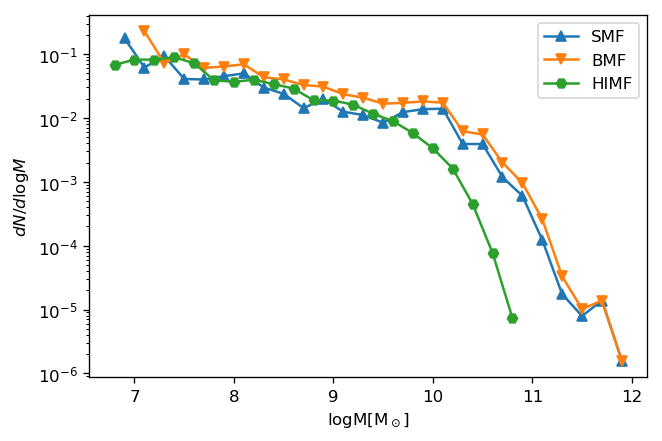

In [7]:
# Plot the mass functions to have a look
plt.figure(dpi=120)
plt.semilogy(SMF[:, 0][SMF_ids], SMF[:, 1][SMF_ids], label='SMF', marker='^')
plt.semilogy(BMF[:, 0][BMF_ids], BMF[:, 1][BMF_ids], label='BMF', marker='v')
plt.semilogy(HIMF[:, 0][HIMF_ids], HIMF[:, 1][HIMF_ids], label='HIMF', marker='H')
plt.xlabel(r'$\log\mathrm{M}[\mathrm{M}_\odot]$')
plt.ylabel(r'${d N}/{d\log M}$')
plt.legend()
plt.show()

## Abundance matching:

In [8]:
def vvir_from_cosmology(halos, cosmology):
    """
    Computes the peak virial velocity from cosmology, to be used in computing the halo proxy.
    """
    z_mpeak = (1.0-halos['mpeak_scale'])/halos['mpeak_scale']
    OmegaM_mpeak = density.omega_M_z(z_mpeak, **cosmology)
    Delta_vir = (18.0*np.pi**2+82*(OmegaM_mpeak-1.0)-39.0*(OmegaM_mpeak-1.0)**2)/OmegaM_mpeak
    rho_crit, rho_mean = density.cosmo_densities(**cosmology)*u.Msun/(u.Mpc**3)
    Rvir_mpeak = (3.0*halos['mpeak']*u.Msun/(4.0*np.pi*rho_crit*Delta_vir))**(1.0/3.0)
    vvir_mpeak = np.sqrt(const.G*halos['mpeak']*u.astrophys.solMass/Rvir_mpeak).to(u.km/u.s)
    return vvir_mpeak.value

### Choose parameters for AF and cosmology

In [9]:
# Halo proxy
alpha = 0.
# Cosmological parameters
cosmology = {u'h': 0.688, u'omega_lambda_0': 0.705, u'omega_k_0': 0.0, u'omega_M_0': 0.295}
# Size of simulation box size
box_size = 400.0 #in Mpc

In [10]:
halos = np.load("../BAM/hlist_1.00000.npy")

In [12]:
halos.dtype.names

('id',
 'pid',
 'upid',
 'mvir',
 'macc',
 'mpeak',
 'vmax',
 'vpeak',
 'Vmax@Mpeak',
 'vacc',
 'x',
 'y',
 'z',
 'vz',
 'rvir',
 'rs',
 'mpeak_scale',
 'rs_klypin',
 'spin')

In [15]:
!ls ../BAM

a100_match.csv	     AM_Baryon_SMF_mod2.py   HIMF_full.dat
a100springfull.fits  AM_Baryon_SMF_mod.py    hlist_1.00000.npy
AM_Baryon_BMF_2.py   AM_Baryon_SMF.py	     nsaalfalfa5asmatch.fits
AM_Baryon_BMF.py     BMF_bin_abundance.dat   Old
AM_Baryon_HIMF.py    BMF_full.dat	     smf_bernardi_ser.dat
AM_Baryon_Loop.py    Catalog_Baryon	     SMF_bin_abundance.dat
AM_Baryon.py	     HIMF_bin_abundance.dat  SMF_full.dat


### Load halos, pick observational mass function, name some halos parameters

In [4]:
# Halos list from N-body
halos = np.load("../BAM/hlist_1.00000.npy")
# Mass function (was loaded into memory previously)
mf_name = 'BMF'
mf = BMF
vvir = vvir_from_cosmology(halos, cosmology)
vmax = halos['Vmax@Mpeak']
mvir = halos['mvir']/0.688 # Put virial mass into physical Msun units
conc = halos['rvir']/halos['rs_klypin']
x_pos = halos['x']
y_pos = halos['y']
z_pos = halos['z']

NameError: name 'np' is not defined

In [3]:
halos

NameError: name 'halos' is not defined

### Setup the abundance matching

In [7]:
# Abundances are not logged, masses are logged
af =  amatch.AbundanceFunction(mf[:,0], mf[:,1], (5., 13.), faint_end_first=True)
# Halo matching proxy parameter
plist = vvir*(vmax/vvir)**alpha

# Calculate the number densities for the halo proxy parameter
nd_halos = amatch.calc_number_densities(plist, box_size)
# Do abundance matching, match the number densities. Here 0 scatter
catalog = af.match(nd_halos)

### Abundance matching deconvolution to create catalogs

In [8]:
Niter = 1
# Do the deconvolution a number of times for different values of scatter.
# For each iteration number prints the catalog length and how many nans are in it.
for i in range(Niter):
    scatter = 0.16
    # Deconvolute the abundance function with a given scatter (assuming Gaussian)
    af.deconvolute(scatter, repeat=20)
    catalog_16 = af.match(nd_halos, scatter)
    
    scatter = 0.4
    af.deconvolute(scatter, repeat=50)
    catalog_40 = af.match(nd_halos, scatter)
    
    mask = (~np.isnan(catalog)) & (catalog>7.)
    
    # Create a structured array..
    N = mvir[mask].size
    catalog_final = np.zeros(N, dtype={'names':('mvir', 'conc', 'cat00', 
                                               'cat16', 'cat40', 'x', 'y', 'z'),
                          'formats':('f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8', 'f8')})
    catalog_final['mvir'] = mvir[mask]
    catalog_final['conc'] = conc[mask]
    catalog_final['cat00'] = catalog[mask]
    catalog_final['cat16'] = catalog_16[mask]
    catalog_final['cat40'] = catalog_40[mask]
    catalog_final['x'] = x_pos[mask]
    catalog_final['y'] = y_pos[mask]
    catalog_final['z'] = z_pos[mask]
    
    
    catalog_final_isnan = np.transpose(np.array([mvir[mask], conc[mask], catalog[mask],
                                           catalog_16[mask], catalog_40[mask]]))
    
    masknan = np.isnan(catalog_final_isnan)
    print i, len(catalog_final_isnan), len(catalog_final_isnan[masknan])
    np.save('../Catalog_Baryon/Catalog_'+ str(mf_name) + '_Iter'
            +str(i)+'_Alpha' +str(alpha).replace('.', ',')+'.npy', catalog_final)
    
    

0 11036961 0


In [19]:
hm = np.log10(catalog_final['mvir'])
sm =(catalog_final['cat16'])

In [20]:
print hm.min(), hm.max()
print sm.min(), sm.max()

9.646796827688982 15.692252402439825
6.295286969329082 12.065491451160783


In [40]:
float(hm[np.where(np.logical_or(hm < 11.5, hm > 14.5 ))].size)/hm.size

0.8980235592025739

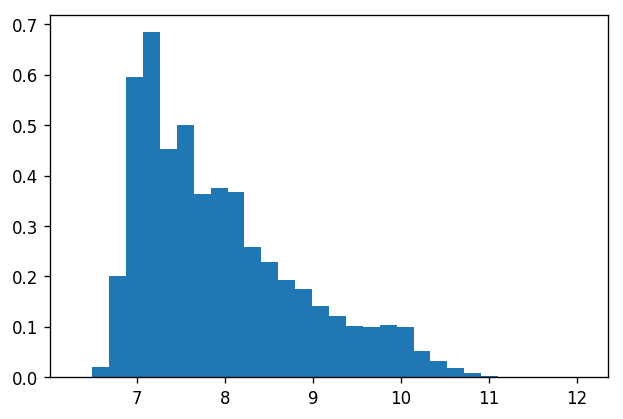

In [34]:
plt.figure(dpi=120)
plt.hist(sm, bins=30, density=1)
plt.savefig('baryonic_mass.png')
plt.show()

In [38]:
catalog_final['z'].min()

2e-05